## Imports

In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.pyplot import cm

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd
import pickle 

%matplotlib inline


from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import f_oneway

In [2]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks and pump_on) in framenumber
    
    args
    filename - string 
    
    returns 
    licks_fn - lits of integers
        framenumber of licks
    pump_on_fn - list of integers 
        framenumber when pump turns on
    
    '''
    df= pd.read_csv(filename)
    
    #Extracts pump on framenumber
    pump_fn = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    
    
    #Extracts licks framenumber
    licks_fn = list (df[df['Item1']== 'Lick']['Item2.Item2'])

      
    return pump_fn, licks_fn
        


In [3]:
def get_hit_miss_trial (pump_fn, licks_fn): 
    '''
    function to get hit and miss trials
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    hit_trial - list of int 
        pump on frame number in hit trials (lick > 0)
    miss_trial - list of int 
        pump on frame number in missed trials (lick = 0)
    
    '''
    hit_trial=[]
    miss_trial=[]
    for p in pump_fn: 
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100: 
                temp.append(lick)
            
        if len(temp)> 0:
            hit_trial.append(p)
        if len(temp) == 0: 
            miss_trial.append(p)
    return hit_trial, miss_trial

In [4]:
def get_licks_trial (pump_fn, licks_fn, triallength=100):
    '''
    function to get licks within one trial 
    licks aligned to pump on (pump_fn)
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    licks_trial - list of list of integers
        list of all licks in all trials aligned to pump on (in frames)
    licks_all_trial - list of integers
        number of licks of each trial 
    licks_hit_trial - list of integers 
        number of licks per trial for hit trials 
    latency - list of integers
        latency to first lick after pump on (in frames)
        
    
    '''

    # All licks aligned to pump on 
    licks_trial=[]
    for p in pump_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > (p) and lick < p + 100:
                temp.append(lick - p)
        licks_trial.append(temp)
        
        
    #licks per trial (all and hit trials) aligned to pump on 
    licks_all_trial=[]
    licks_hit_trial=[]
    for trial in licks_trial: 
        licks_all_trial.append(len(trial))
        if len(trial) > 0: 
            licks_hit_trial.append(len(trial))
            
            
    #Latency to first lick after pump on
    temp_latency=[]
    latency_all_temp=[]
    for trial in licks_trial:
        latency_all_temp.append(trial[:1])
        if len(trial) > 0: 
            temp_latency.append(trial[:1])
        
            
    
    latency=[trial for sublist in temp_latency for trial in sublist] #List comprehension to convert list of lists to flat list     
    
        
    return licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all_temp

In [5]:
def get_binned_latency(latency_all): 
    '''
    function to get mean latency for binned trials  
    bins = 10 trials 
    
    args
    latency_all - list of lists of int
        list all the latencies to first lick in each trial. if no lick list is empty 
        
    returns 
    latency1/2/3/4 - float 
        the mean latency for hit trials in 4 different bins (10 trial per bin)
    '''
    bin1=tp.flatten_list(latency_all[:10])
    bin2=tp.flatten_list(latency_all[10:20])
    bin3=tp.flatten_list(latency_all[20:30])
    bin4=tp.flatten_list(latency_all[30:])

    latency1=np.mean(bin1)
    latency2=np.mean(bin2)
    latency3=np.mean(bin3)
    latency4=np.mean(bin4)
    
    return latency1,latency2,latency3,latency4

In [6]:
def get_grouped_latencybin(diet,solution, session):

    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session and len(d['pump_fn']) > 30: 
            if d['latency1'] > 0:
                bin1.append(d['latency1'])
            if d['latency2'] > 0:
                bin2.append(d['latency2'])
            if d['latency3'] > 0:
                bin3.append(d['latency3'])
            if d['latency4'] > 0:
                bin4.append(d['latency4'])
        


    b1_m=np.mean(bin1)
    b1_E=np.std(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.mean(bin2)
    b2_E=np.std(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.mean(bin3)
    b3_E=np.std(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.mean(bin4)
    b4_E=np.std(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    
    return mean,error
    

In [7]:
def get_binned_hit (data): 
    
    bin1=data[:10]
    bin2=data[10:20]
    bin3=data[20:30]
    bin4=data[30:]


    hit1=[]
    miss1=[]
    for trial in bin1: 
        if len(trial)>0: 
            hit1.append(trial[:1])
        elif len(trial)==0: 
            miss1.append(trial)
        
    try: 
        p_bin1 =(len(hit1)/(len(hit1)+len(miss1)))*100
    except ZeroDivisionError:
        p_bin1=np.nan

    hit2=[]
    miss2=[]
    for trial in bin2: 
        if len(trial)>0: 
            hit2.append(trial[:1])
        elif len(trial)==0: 
            miss2.append(trial)
            
    try: 
        p_bin2 =(len(hit2)/(len(hit2)+len(miss2)))*100
    except ZeroDivisionError:
        p_bin2=np.nan

    hit3=[]
    miss3=[]
    for trial in bin3: 
        if len(trial)>0: 
            hit3.append(trial[:1])
        elif len(trial)==0: 
            miss3.append(trial)
            
    try: 
        p_bin3 =(len(hit3)/(len(hit3)+len(miss3)))*100
    except ZeroDivisionError:
        p_bin3=np.nan
    

    hit4=[]
    miss4=[]
    for trial in bin4:
        if len(trial)>0: 
            hit4.append(trial[:1])
        elif len(trial)==0: 
            miss4.append(trial)
            
    try: 
        p_bin4 =(len(hit4)/(len(hit4)+len(miss4)))*100
    except ZeroDivisionError:
        p_bin4=np.nan
            
    
    
    return p_bin1,p_bin2,p_bin3,p_bin4

In [8]:
def make_barscatter(data, ax=None, barlabels=['PR','PRNR','NR','NRPR'], barfacecolor = ['darkcyan','c', 'black', 'grey']):
    
    '''
    function to make barscatter
    
    arg 
    data - list of lists of floats
        The data you want to put into the plot
    barlabels - list of strings
        labels for the bars plotted (optional - defaulte : 'PR','PRNR','NR','NRPR' )
    barfacecolors - list of strings
        colors for the bars (optional- default: ['darkcyan','c', 'black', 'grey'])
    
    
    returns 
    ax - ax to put into sublot
    
    '''
    if ax == None: 
        f,ax = plt.subplots()
        
    tp.barscatter(data, 
#                   paired= True,
                  barfacecolor=barfacecolor,
                  barlabels=barlabels,
                  barlabeloffset=0.04,
                  barfacecolor_option='individual',
                  fontsize = 13,
                  scattersize=110,
                  scatteralpha=0.7,
                  spaced=True,
                  linewidth=1.5,
                  ax=ax)
    
    return ax
    

In [9]:
def get_cumulative_licks(licks_fn): 
    '''
    function to get cumulative licks. 
    lick frame number put into bins and calculated as cumulative
    
    args 
    licks_fn - list of floats 
        the framenumber of all licks in the session 
    bins - float - optional default set to 100 (10 sec)
        size of bins
        
    returns
    lickcum - array of cumulative licks 
    lickbin - array of bins '''
    
    bins=list(range(0,12900,10))
    licks, b = np.histogram(licks_fn, bins=bins)
    lickcum = np.cumsum(licks)
    lickbin = b[1:]
    
    return lickcum, lickbin

In [10]:
def get_grouped_data(dictionary, solution, data ):
    '''
    function to group data and get output from animals grouped into PR, PRNR, NR and NRPR
    
    args
    dictionary - name of dictionaty (eks behav_data)
    solution - string 
        the name of the soltuion, given as a key in the dictionaty (eks 'Ensure')
    data - string
        name of the data/output you want as output (eks 'total licks') 
        
        
        
    '''
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for mouse in mice: 
        temp_PR=[]
        temp_PRNR=[]
        
        temp_NR=[]
        temp_NRPR=[]
        
        for key in dictionary.keys():
            d=dictionary[key]
            
            if d['mouse']== mouse and d['solution']==solution and d['diet']== 'PR': 
                temp_PR.append(d[data])
                temp_PR = [element for element in temp_PR if not np.isnan(element)]
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NR':
                temp_NR.append(d[data])
                temp_NR = [element for element in temp_NR if not np.isnan(element)]
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'PRNR':
                temp_PRNR.append(d[data])
                temp_PRNR = [element for element in temp_PRNR if not np.isnan(element)]
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NRPR':
                temp_NRPR.append(d[data])
                temp_NRPR = [element for element in temp_NRPR if not np.isnan(element)]
                
        if len(temp_PR)> 0:
            PR.append(np.mean(temp_PR))
        if len(temp_NR)>0:
            NR.append(np.mean(temp_NR))
        if len(temp_PRNR)>0:
            PRNR.append(np.mean(temp_PRNR))
        if len(temp_NRPR)>0:
            NRPR.append(np.mean(temp_NRPR))
            
    return PR, PRNR, NR, NRPR
                
        

In [11]:
def grouped_by_session(dictionary, solution,session, output):
    
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for key in dictionary.keys():
            d=dictionary[key]
            
            if d['solution']== solution and d['diet'] == 'PR' and d['session'] == session: 
                PR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'PRNR' and d['session'] == session: 
                PRNR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NR' and d['session'] == session: 
                NR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NRPR' and d['session'] == session: 
                NRPR.append(np.mean(d[output]))
                
                
    return PR, PRNR, NR, NRPR
        
   

In [12]:
def get_kde(licks_fn, band_width=0.2):
    # Exclude empty lists and flatten the remaining lists
    flattened_data = [item for sublist in licks_fn if sublist for item in sublist]
    
    # Create the Gaussian KDE
    G = gaussian_kde(flattened_data, bw_method=band_width)
    
    # Define the range of values for which you want the KDE
    x = np.arange(-50, 100)
    
    return G(x)






## Metafile reader

In [13]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.3.xls',sheetname='Behavior')
# rows_homecage,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Homecage')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


## Dictionary

In [14]:
all_data={}

for row in rows: 
    try:
        key=row[0]+ '_' + row[4]
    
        pump_fn, licks_fn = extract_event_fn(folder+row[1])
        hit_trial, miss_trial = get_hit_miss_trial(pump_fn, licks_fn)
        licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all = get_licks_trial(pump_fn, licks_fn)
        cumlicks, bins = get_cumulative_licks(licks_fn)
        
        
        latency1, latency2, latency3, latency4 = get_binned_latency(latency_all)
#         if len(pump_fn) > 30: 

        hit1, hit2, hit3, hit4 = get_binned_hit(latency_all)
    
        
        
    
        all_data[key]={}

        all_data[key]['mouse']=row[0]
        all_data[key]['diet']=row[7]
        all_data[key]['solution']=row[8]
        all_data[key]['session']=row[10]
    
#         all_data[key]['file']=row[1]
#         all_data[key]['licks_fn']= licks_fn
        all_data[key]['pump_fn']= pump_fn
        all_data[key]['licks trial']= licks_trial
#         all_data[key]['number of trials']=len(pump_fn)
        all_data[key]['total licks']=len(licks_fn)
#         all_data[key]['hit trial'] = len(hit_trial)
        all_data[key]['% hit']=(len(hit_trial)/(len(pump_fn))*100)
#         all_data[key]['miss trials']= len(miss_trial)
        all_data[key]['licks per trial']= np.mean(licks_all_trial)
        all_data[key]['licks hit trial']= np.mean(licks_hit_trial)
        all_data[key]['latency']= np.mean(latency)
        
#         all_data[key]['latency all']=latency_all
        all_data[key]['latency1']=latency1
        all_data[key]['latency2']=latency2
        all_data[key]['latency3']=latency3
        all_data[key]['latency4']=latency4
        
        all_data[key]['hit 1']= hit1
        all_data[key]['hit 2']= hit2
        all_data[key]['hit 3']= hit3
        all_data[key]['hit 4']= hit4
        
        
        all_data[key]['cumulative licks']=cumlicks
        all_data[key]['lick bins']=bins
        
    
    except FileNotFoundError: 
        print('Cannot find file for', key)

C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cannot find file for _


In [15]:

with open('..//output//behavdata.pickle', 'wb') as file:
    pickle.dump(all_data, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('..//output//behavdata.pickle', 'rb') as file:
    b = pickle.load(file)

In [16]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)


for m in mice: 
    if m == 'VGP305':
        mice.remove(m)





# Licks per trial (all)

In [17]:
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'licks per trial')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'licks per trial')



## Preference for casein - total number of licks

In [18]:

#Preference for PR 
pref_PR=[]
for cas in cas_PR:
    pref_temp=[]
    for malt in malt_PR: 
        pref_temp=(cas/(cas+malt))
    pref_PR.append(pref_temp)
    
pref_PR  

# Preference for NR 

pref_NR=[]
for cas in cas_NR:
    pref_temp=[]
    for malt in malt_NR: 
        pref_temp=(cas/(cas+malt))
    pref_NR.append(pref_temp)
    
pref_NR  

# Preference for PRNR 

pref_PRNR=[]
for cas in cas_PRNR:
    pref_temp=[]
    for malt in malt_PRNR: 
        pref_temp=(cas/(cas+malt))
    pref_PRNR.append(pref_temp)
    
pref_PRNR  


# Preference for NRPR 

pref_NRPR=[]
for cas in cas_NRPR:
    pref_temp=[]
    for malt in malt_NRPR: 
        pref_temp=(cas/(cas+malt))
    pref_NRPR.append(pref_temp)
    


In [19]:
NR_pref2=[]
for row in pref_NR: 
    NR_pref2.append(row - 0.5)
    
NRPR_pref2=[]
for row in pref_NRPR: 
    NRPR_pref2.append(row - 0.5)
    
PR_pref2=[]
for row in pref_PR: 
    PR_pref2.append(row - 0.5)
    
PRNR_pref2=[]
for row in pref_PRNR: 
    PRNR_pref2.append(row - 0.5)

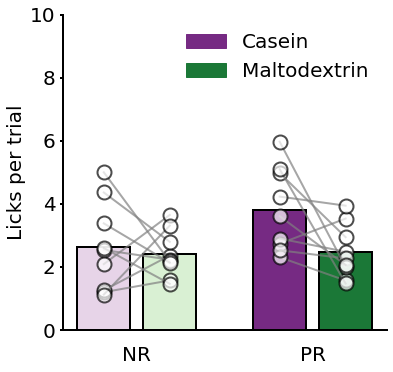

In [24]:
f, ax = plt.subplots(figsize=(6,6),ncols=1, sharey=False)
f.subplots_adjust(wspace=0.5,hspace=0.2, bottom=0.15, left=0.2, right=0.95)

colors_C=['#e7d4e8', '#d9f0d3','#762a83','#1b7837']


tp.barscatter([[cas_NR,malt_NR],[cas_PR,malt_PR]], 
              paired= True,
              barfacecolor=colors_C,
              grouplabel=['NR', 'PR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 20,
              scattersize=140,
              scatteralpha=0.7,
              spaced=True,
              linewidth=2,
              ax=ax)

ax.set_yticks([0,2,4, 6,8,10])
ax.set_yticklabels([0,2,4, 6,8,10], size=20)
ax.set_ylabel("Licks per trial", size=20)
    
    
colors = {'Casein':'#762a83', 'Maltodextrin':'#1b7837'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
ax.legend(handles, labels, frameon=False, fontsize=20)

f.savefig('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\Presentations\\NordicNeuroscience 2024\\Figs\\licks_cond1.pdf')

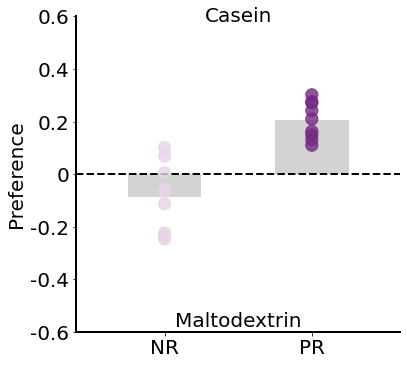

In [31]:
# f, ax = plt.subplots(figsize=(5,5),ncols=1, sharey=False)
# f.subplots_adjust(wspace=0.5,hspace=0.2, bottom=0.15, left=0.2, right=0.95)


f, ax = plt.subplots(figsize=(6,6),ncols=1, sharey=False)
f.subplots_adjust(wspace=0.5,hspace=0.2, bottom=0.15, left=0.2, right=0.95)
x1=[1,2]


for row in zip(NR_pref2,PR_pref2):
    y1=row
#     ax[1].plot(x1,y1, color='grey')
    ax.scatter(x1,y1, s=150, color=["#e7d4e8", "#762a83"], zorder=20, alpha=0.8)
    

    
ax.bar(x1, [np.mean(NR_pref2),np.mean(PR_pref2)], width=0.5, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Preference", size=20)
ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6], size=20)



ax.set_xticks([1,2])
ax.set_xticklabels(["NR", 'PR'], size=20)
ax.set_xlim([0.4,2.6])

ax.axhline(0, color="k", linestyle="--", zorder=-1,lw=2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


ax.text(1.5, 0.58, "Casein", horizontalalignment='center',color='black', size=20)
ax.text(1.5, -0.58, "Maltodextrin",horizontalalignment='center',color='black', size=20)


f.savefig('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\Presentations\\NordicNeuroscience 2024\\Figs\\pref_cond1.pdf')

In [65]:
print('Licks p')


t_value,p_value=stats.ttest_ind(cas_PR,cas_NR)
print('T-test (PR NR_C) = %f'%p_value)

t_value,p_value=stats.ttest_ind(malt_PR,malt_NR)
print('T-test (PR NR_M) = %f'%p_value)

t_value,p_value=stats.ttest_rel(malt_PR,cas_PR)
print('T-test(PR C_M) = %f'%p_value)

t_value,p_value=stats.ttest_rel(malt_NR,cas_NR)
print('T-test(NR C_M) = %f'%p_value)


t_value,p_value=stats.ttest_ind(cas_PRNR,cas_NRPR)
print('T-test (PRNR NRPR_C) = %f'%p_value)
t_value,p_value=stats.ttest_ind(malt_PRNR,malt_NRPR)
print('T-test (PRNR NRPR_M) = %f'%p_value)


t_value,p_value=stats.ttest_rel(malt_NRPR,cas_NRPR)
print('T-test(NRPR C_M) = %f'%p_value)
t_value,p_value=stats.ttest_rel(cas_PRNR,malt_PRNR)
print('T-test(PRNR C_M) = %f'%p_value)

Licks p
T-test (PR NR_C) = 0.078776
T-test (PR NR_M) = 0.863810
T-test(PR C_M) = 0.036876
T-test(NR C_M) = 0.715557
T-test (PRNR NRPR_C) = 0.227834
T-test (PRNR NRPR_M) = 0.558640
T-test(NRPR C_M) = 0.006906
T-test(PRNR C_M) = 0.172648


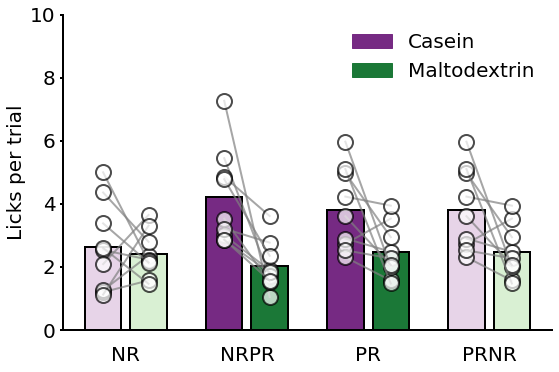

In [25]:
f, ax = plt.subplots(figsize=(8,6),ncols=1, sharey=False)
f.subplots_adjust(wspace=0.4,hspace=0.2, bottom=0.15, left=0.1, right=0.95)

colors_C=['#e7d4e8', '#d9f0d3','#762a83','#1b7837','#762a83','#1b7837','#e7d4e8','#d9f0d3']


tp.barscatter([[cas_NR,malt_NR],[cas_NRPR,malt_NRPR],[cas_PR,malt_PR],[cas_PR,malt_PR]], 
              paired= True,
              barfacecolor=colors_C,
              grouplabel=['NR','NRPR', 'PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 20,
              scattersize=150,
              scatteralpha=0.7,
              spaced=True,
              linewidth=2,
              ax=ax)

ax.set_yticks([0,2,4, 6,8,10])
ax.set_yticklabels([0,2,4, 6,8,10], size=20)
ax.set_ylabel("Licks per trial", size=20)

    
colors = {'Casein':'#762a83', 'Maltodextrin':'#1b7837'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
ax.legend(handles, labels, frameon=False, fontsize=20)


f.savefig('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\Presentations\\NordicNeuroscience 2024\\licks_cond2.pdf')


<ipython-input-60-de31442d5871>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels([0,2,4, 6,8,10], size=20)


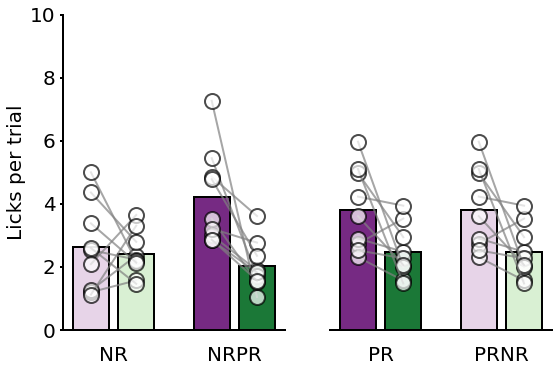

In [60]:
f, ax = plt.subplots(figsize=(8,6),ncols=2, sharey=True)
f.subplots_adjust(wspace=0.2,hspace=0.2, bottom=0.15, left=0.1, right=0.95)

colors_1=['#e7d4e8', '#d9f0d3','#762a83','#1b7837','#762a83','#1b7837','#e7d4e8','#d9f0d3']
colors_2=['#762a83','#1b7837','#e7d4e8','#d9f0d3']


tp.barscatter([[cas_NR,malt_NR],[cas_NRPR,malt_NRPR]], 
              paired= True,
              barfacecolor=colors_1,
              grouplabel=['NR','NRPR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 20,
              scattersize=150,
              scatteralpha=0.7,
              spaced=True,
              linewidth=2,
              ax=ax[0])

tp.barscatter([[cas_PR,malt_PR],[cas_PR,malt_PR]], 
              paired= True,
              barfacecolor=colors_2,
              grouplabel=['PR','PRNR'],
              barlabeloffset=0.04,
              barfacecolor_option='individual',
              fontsize = 20,
              scattersize=150,
              scatteralpha=0.7,
              spaced=True,
              linewidth=2,
              ax=ax[1])

ax[0].set_yticklabels([0,2,4, 6,8,10], size=20)
ax[0].set_ylabel("Licks per trial", size=20)
ax[0].set_yticks([0,2,4, 6,8,10])

ax[1].set_yticks([0,2,4, 6,8,10])
ax[1].tick_params(left = False) 



ax[1].spines["left"].set_visible(False)
    
# colors = {'Casein':'#762a83', 'Maltodextrin':'#1b7837'}         
# labels = list(colors.keys())
# handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
# ax[0].legend(handles, labels, frameon=False, fontsize=20)


f.savefig('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\Presentations\\NordicNeuroscience 2024\\Figs\\licks_cond2.pdf')

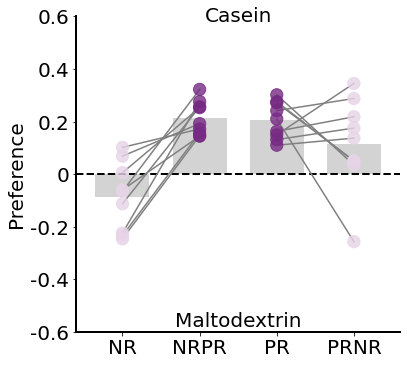

In [34]:
f, ax = plt.subplots(figsize=(6,6),ncols=1, sharey=False)
f.subplots_adjust(wspace=0.5,hspace=0.2, bottom=0.15, left=0.2, right=0.95)


x1=[1,2]
x2=[3,4]

for row in zip(NR_pref2,NRPR_pref2):
    y1=row
    ax.plot(x1,y1, color='grey')
    ax.scatter(x1,y1, s=150, color=["#e7d4e8", "#762a83"], zorder=20, alpha=0.8)
    
for row in zip(PR_pref2,PRNR_pref2):
    y2=row
    ax.plot(x2,y2, color='grey')
    ax.scatter(x2,y2, s=150, color=["#762a83", "#e7d4e8"], zorder=20, alpha=0.8)
    

    
ax.bar(x1, [np.mean(NR_pref2),np.mean(NRPR_pref2)], width=0.7, zorder=-1, color="lightgrey")
ax.bar(x2, [np.mean(PR_pref2),np.mean(PRNR_pref2)], width=0.7, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Preference", size=20)
ax.set_yticks([-0.6,-0.4,-0.2,0,0.2,0.4,0.6])
ax.set_yticklabels([-0.6,-0.4,-0.2,0,0.2,0.4,0.6], size=20)



ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["NR", 'NRPR','PR','PRNR'], size=20)
ax.set_xlim([0.4,4.6])



ax.axhline(0, color="k", linestyle="--", zorder=-1,lw=2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


ax.text(2.5, 0.58, "Casein", horizontalalignment='center',color='black', size=20)
ax.text(2.5, -0.58, "Maltodextrin",horizontalalignment='center',color='black', size=20)

# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\preference_trial_scatter.png')
f.savefig('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\Presentations\\NordicNeuroscience 2024\\Figs\\pref_cond2.pdf')

### Stats - casein preference

In [27]:
# # paried t-test: 
# stats_PR_PRNR=stats.ttest_ind(PR_pref2, PRNR_pref2)
# print('PR_PRNR',stats_PR_PRNR)

# stats_NR_NRPR=stats.ttest_ind(NR_pref2, NRPR_pref2)
# print('NR_NRPR',stats_NR_NRPR)

# stats_NR_PR=stats.ttest_ind(PR_pref2,NR_pref2)
# print('NR_PR',stats_NR_PR)

# stats_NRPR_PRNR=stats.ttest_ind(NRPR_pref2, PRNR_pref2)
# print('NRPR_PRNR',stats_NRPR_PRNR)



# test if there is a preference
expected_value=0.5
t_statistic, p_value = stats.ttest_1samp(pref_PRNR, expected_value)
print(p_value)


0.08528796531832522
